In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from string import punctuation
stop_words = set( stopwords.words('english'))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

spacy.load('en_core_web_lg')

import os
from os import walk
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rchaks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rchaks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rchaks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/rchaks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Identify Fallen Angels

In [69]:
df = pd.read_csv('changed_debt_rating.csv').drop('Unnamed: 0', axis = 1)
df['datadate'] = pd.to_datetime(df['datadate'])
df['year'] = df['datadate'].dt.year

df = df.set_index('datadate')
df = df.dropna(subset = ['splticrm'])

df['next_splticrm'] = df.groupby(['tic','gvkey'])['splticrm'].shift(-1)
# df = df.dropna(subset = ['next_splticrm'])

df.dropna(inplace=True)
df

,gvkey,splticrm,busdesc,ggroup,gsector,conm,tic,year,next_splticrm
datadate,,,,,,,,,
1985-12-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1985,A-
1986-01-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-
1986-02-28,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-
1986-03-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-
1986-04-30,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-
...,...,...,...,...,...,...,...,...,...
2016-09-30,186783,BB+,VEREIT is a full-service real estate operating...,6010,60,VEREIT INC,VER,2016,BB+
2016-10-31,186783,BB+,VEREIT is a full-service real estate operating...,6010,60,VEREIT INC,VER,2016,BB+
2016-11-30,186783,BB+,VEREIT is a full-service real estate operating...,6010,60,VEREIT INC,VER,2016,BB+


In [70]:
# User: rkarthick1997
# Pass: ABInBevCapstone5

In [71]:
df.splticrm.value_counts().index

Index(['BBB', 'BB', 'BBB-', 'BB+', 'B+', 'BB-', 'A-', 'BBB+', 'B', 'CC', 'CCC',
       'D', 'B-', 'CCC+', 'CCC-'],
      dtype='object')

In [72]:
def is_invest_grade(rating: str)->bool:
    return rating.startswith('A') or rating in {'BBB','BBB+'}

def junk_drop(rating:str, next_rating:str):
    grade = 'invest'
    out = []
    for item in zip(rating, next_rating):
        if is_invest_grade(item[0]) == True:
            if is_invest_grade(item[1]) == False:
                grade = 'fallen'
        else:
            grade = 'junk'
        out.append(grade)
    return out


df['grade'] = junk_drop(df['splticrm'],df['next_splticrm'])
df

,gvkey,splticrm,busdesc,ggroup,gsector,conm,tic,year,next_splticrm,grade
datadate,,,,,,,,,,
1985-12-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1985,A-,invest
1986-01-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-,invest
1986-02-28,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-,invest
1986-03-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-,invest
1986-04-30,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1986,A-,invest
...,...,...,...,...,...,...,...,...,...,...
2016-09-30,186783,BB+,VEREIT is a full-service real estate operating...,6010,60,VEREIT INC,VER,2016,BB+,junk
2016-10-31,186783,BB+,VEREIT is a full-service real estate operating...,6010,60,VEREIT INC,VER,2016,BB+,junk
2016-11-30,186783,BB+,VEREIT is a full-service real estate operating...,6010,60,VEREIT INC,VER,2016,BB+,junk


In [73]:
def compare(x):
    if any(x.grade == 'fallen'):
        return x[x.grade.apply(lambda i: i in {'invest','fallen'})].drop('year', axis = 1)
    else:
        return x[x.grade.apply(lambda i: i  == 'invest')].drop('year', axis = 1)
    # print(type(x), x.columns)

In [74]:
df = df.groupby('year').apply(compare).reset_index()#.set_index('datadate')
df

,year,datadate,gvkey,splticrm,busdesc,ggroup,gsector,conm,tic,next_splticrm,grade
0,1985,1985-12-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,invest
1,1986,1986-01-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,invest
2,1986,1986-02-28,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,invest
3,1986,1986-03-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,invest
4,1986,1986-04-30,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,invest
...,...,...,...,...,...,...,...,...,...,...,...
90,2006,2006-11-30,174022,BBB,"Realogy Holdings Corp., through its subsidiari...",6010,60,REALOGY HOLDINGS CORP,RLGY,BB+,fallen
91,2008,2008-09-30,15142,BBB,iStar Inc. (NYSE: STAR) is focused on reinvent...,6010,60,ISTAR INC,STAR,BBB-,fallen
92,2008,2008-09-30,27780,BBB,SITE Centers is an owner and manager of open-a...,6010,60,SITE CENTERS CORP,SITC,BBB-,fallen
93,2008,2008-09-30,30384,BBB,"First Industrial Realty Trust, Inc. (NYSE: FR)...",6010,60,FIRST INDL REALTY TRUST INC,FR,BBB-,fallen


In [38]:
# def is_invest_grade(rating: str)->bool:
#     return rating.startswith('A') or rating in {'BBB','BBB+'}

# def junk_drop(rating:str, next_rating:str):
#     return rating.apply(lambda x: is_invest_grade(x) == True) & next_rating.apply(lambda x: is_invest_grade(x) == False)


# df = df[junk_drop(df['splticrm'],df['next_splticrm'])].reset_index()
# df

,datadate,gvkey,splticrm,busdesc,ggroup,gsector,conm,tic,year,next_splticrm,grade
0,1993-04-30,7063,BBB,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,1993,BB-,fallen
1,2001-05-31,8692,BBB,PotlatchDeltic (NASDAQ:PCH) is a leading Real ...,6010,60,POTLATCHDELTIC CORP,PCH,2001,BBB-,fallen
2,2008-09-30,15142,BBB,iStar Inc. (NYSE: STAR) is focused on reinvent...,6010,60,ISTAR INC,STAR,2008,BBB-,fallen
3,2008-09-30,27780,BBB,SITE Centers is an owner and manager of open-a...,6010,60,SITE CENTERS CORP,SITC,2008,BBB-,fallen
4,2008-09-30,30384,BBB,"First Industrial Realty Trust, Inc. (NYSE: FR)...",6010,60,FIRST INDL REALTY TRUST INC,FR,2008,BBB-,fallen
5,2014-03-31,30637,BBB,"Veris Residential, Inc.",6010,60,MACK-CALI REALTY CORP,VRE,2014,BBB-,fallen
6,2006-11-30,174022,BBB,"Realogy Holdings Corp., through its subsidiari...",6010,60,REALOGY HOLDINGS CORP,RLGY,2006,BB+,fallen


In [6]:
## All rating drops counted. Need only Investment grade -> Junk

# rating_list = ['A-','BBB+','BBB-', 'BBB','BB+','BB','BB-', 'B+', 'B','B-',  'CCC+',  'CCC', 'CCC-', 'CC','D']
# df['rating_drop'] = 0

# for i in df.index:
#     if rating_list.index(df.loc[i,'Next Filing Rating']) > rating_list.index(df.loc[i,'splticrm']):
#         df.loc[i,'rating_drop'] = 1
# df.head()
# df[df['rating_drop'] == 1]

In [75]:
def get_year(s):
    s = str(s)
    return int(s[:4])

In [76]:
annual_data = pd.read_csv('annual_data.csv')
annual_data['fyear'] = annual_data['datadate'].map(get_year)
annual_data.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,at,gp,invt,nits,oiadp,revt,txt,cik,costat,mkvalt,ggroup
0,1096,19791130,1979,INDL,C,D,STD,MRCBF,CAD,208.285,24.788,104.198,NaN,22.521,335.783,4.023,NaN,A,NaN,6010
1,1096,19801130,1980,INDL,C,D,STD,MRCBF,CAD,228.348,24.918,109.510,NaN,22.176,349.973,2.101,NaN,A,NaN,6010
2,1096,19811130,1981,INDL,C,D,STD,MRCBF,CAD,239.760,29.777,124.462,NaN,26.293,390.969,-0.088,NaN,A,NaN,6010
3,1096,19821130,1982,INDL,C,D,STD,MRCBF,CAD,202.461,22.428,100.332,NaN,19.415,345.406,-1.217,NaN,A,NaN,6010
4,1096,19831130,1983,INDL,C,D,STD,MRCBF,CAD,189.072,17.336,97.734,NaN,14.645,322.246,0.787,NaN,A,NaN,6010


In [77]:
merged_data = pd.merge(df,annual_data.drop(['datadate','tic'],axis= 1), how = 'left', left_on = ['gvkey','year'], right_on = ['gvkey','fyear'])
merged_data.shape

(100, 28)

In [78]:
merged_data.describe()

,year,gvkey,ggroup_x,gsector,fyear,at,gp,invt,nits,oiadp,revt,txt,cik,mkvalt,ggroup_y
count,100.000000,100.000000,100.0,100.0,100.000000,100.000000,95.000000,100.000000,0.0,95.000000,100.000000,100.000000,1.000000e+02,7.000000,100.0
mean,1991.220000,11932.290000,6010.0,60.0,1991.220000,6073.067580,570.130179,204.839880,NaN,382.072389,6495.966290,100.684850,1.071069e+06,2536.841129,6010.0
std,6.404828,23904.355756,0.0,0.0,6.404828,1736.655232,159.614109,84.859855,NaN,124.742256,2311.231172,63.595569,6.649161e+04,2793.499637,0.0
min,1985.000000,7063.000000,6010.0,60.0,1985.000000,2487.146000,-234.452000,0.000000,NaN,-234.452000,496.806000,-50.793000,8.943150e+05,235.169100,6010.0
25%,1987.750000,7063.000000,6010.0,60.0,1987.750000,5370.500000,565.000000,171.300000,NaN,369.000000,5266.500000,63.000000,1.070750e+06,532.623800,6010.0
50%,1990.000000,7063.000000,6010.0,60.0,1990.000000,6400.000000,620.300000,217.000000,NaN,388.000000,7370.000000,117.000000,1.070750e+06,1697.807600,6010.0
75%,1992.000000,7063.000000,6010.0,60.0,1992.000000,6732.000000,638.000000,249.000000,NaN,453.200000,7646.000000,168.500000,1.070750e+06,4114.367800,6010.0
max,2014.000000,174022.000000,6010.0,60.0,2014.000000,15296.748000,1349.000000,316.000000,NaN,698.000000,8722.000000,237.000000,1.398987e+06,6530.928000,6010.0


In [79]:
merged_data.head()

,year,datadate,gvkey,splticrm,busdesc,ggroup_x,gsector,conm,tic,next_splticrm,...,gp,invt,nits,oiadp,revt,txt,cik,costat,mkvalt,ggroup_y
0,1985,1985-12-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,...,440.299,147.7,NaN,328.399,4241.699,128.3,1070750.0,A,NaN,6010
1,1986,1986-01-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,...,519.100,171.3,NaN,378.000,5266.500,168.5,1070750.0,A,NaN,6010
2,1986,1986-02-28,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,...,519.100,171.3,NaN,378.000,5266.500,168.5,1070750.0,A,NaN,6010
3,1986,1986-03-31,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,...,519.100,171.3,NaN,378.000,5266.500,168.5,1070750.0,A,NaN,6010
4,1986,1986-04-30,7063,A-,"Host Hotels & Resorts, Inc. is an S&P 500 comp...",6010,60,HOST HOTELS & RESORTS INC,HST,A-,...,519.100,171.3,NaN,378.000,5266.500,168.5,1070750.0,A,NaN,6010


In [84]:
fallen_angels = merged_data[['gvkey','tic','cik','datadate','grade']].drop_duplicates()
fallen_angels.cik = fallen_angels.cik.astype(int)
fallen_angels.to_csv('fallen_angels.csv', index= False)
fallen_angels

,gvkey,tic,cik,datadate,grade
0,7063,HST,1070750,1985-12-31,invest
1,7063,HST,1070750,1986-01-31,invest
2,7063,HST,1070750,1986-02-28,invest
3,7063,HST,1070750,1986-03-31,invest
4,7063,HST,1070750,1986-04-30,invest
...,...,...,...,...,...
90,174022,RLGY,1398987,2006-11-30,fallen
92,15142,STAR,1095651,2008-09-30,fallen
94,27780,SITC,894315,2008-09-30,fallen
96,30384,FR,921825,2008-09-30,fallen


# Scrape Edgar

In [90]:
import os
from ut_msba_edgar_scraper import Downloader
from datetime import datetime
import itertools
from tqdm import tqdm

In [91]:
fallen_angels = pd.read_csv('fallen_angels.csv')
fallen_angels.datadate = pd.to_datetime(fallen_angels.datadate)
fallen_angels

,gvkey,tic,cik,datadate,grade
0,7063,HST,1070750,1985-12-31,invest
1,7063,HST,1070750,1986-01-31,invest
2,7063,HST,1070750,1986-02-28,invest
3,7063,HST,1070750,1986-03-31,invest
4,7063,HST,1070750,1986-04-30,invest
...,...,...,...,...,...
90,174022,RLGY,1398987,2006-11-30,fallen
91,15142,STAR,1095651,2008-09-30,fallen
92,27780,SITC,894315,2008-09-30,fallen
93,30384,FR,921825,2008-09-30,fallen


In [102]:
fallen_angels[fallen_angels.datadate.dt.year >= 2000]

,gvkey,tic,cik,datadate,grade
89,8692,PCH,1338749,2001-05-31,fallen
90,174022,RLGY,1398987,2006-11-30,fallen
91,15142,STAR,1095651,2008-09-30,fallen
92,27780,SITC,894315,2008-09-30,fallen
93,30384,FR,921825,2008-09-30,fallen
94,30637,VRE,924901,2014-03-31,fallen


In [103]:
x=[1,2,3]
x[::-1]

[3, 2, 1]

In [106]:
def fetch_reports(args):
    downloader = Downloader()
    report_type, date, gvkey, grade = args
    date = datetime(year = 2002, month=12, day= 31) if date.year <2000 else date
    after_date = date.replace(year = date.year -2) if date.year >=2002 else datetime(year = 2000, month=1, day= 1)
    
    print(f"{report_type}, {date.strftime('%Y-%m-%d')}, {after_date.strftime('%Y-%m-%d')}, {gvkey}")
    
    filings_list = downloader.get_filings(report_type,
                                        gvkey, 
                                        before= date.strftime('%Y-%m-%d'),
                                        after = after_date.strftime('%Y-%m-%d'))
    
    flag = True if grade == 'fallen' else False
    for filing in filings_list[::-1]:
        if flag == True:
            os.makedirs(f'data/raw/fallen/', exist_ok=True)
            with open(f'data/raw/fallen/{repr(filing)}.html','wb') as f:
                f.write(filing.get_report())    
            flag = False
            continue
        
        os.makedirs(f'data/raw/invest/', exist_ok=True)
        with open(f'data/raw/invest/{repr(filing)}.html','wb') as f:
            f.write(filing.get_report())
    

In [107]:
os.makedirs('fallen_angels/raw', exist_ok = True)
for rows, report_type in itertools.product(fallen_angels.values.tolist(), ['10-K','10-Q']):
    gvkey, ticker, cik, date, grade = rows
    if date.year >= 2000:
        fetch_reports((report_type, date, gvkey, grade))

10-K, 2001-05-31, 2000-01-01, 8692
10-Q, 2001-05-31, 2000-01-01, 8692
10-K, 2006-11-30, 2004-11-30, 174022
10-Q, 2006-11-30, 2004-11-30, 174022
10-K, 2008-09-30, 2006-09-30, 15142
10-Q, 2008-09-30, 2006-09-30, 15142
10-K, 2008-09-30, 2006-09-30, 27780
10-Q, 2008-09-30, 2006-09-30, 27780
10-K, 2008-09-30, 2006-09-30, 30384
10-Q, 2008-09-30, 2006-09-30, 30384
10-K, 2014-03-31, 2012-03-31, 30637
10-Q, 2014-03-31, 2012-03-31, 30637


In [115]:
!pwd

/Users/rchaks/.zshenv:1: bad assignment
/Users/rchaks/Code/GitHub/fin-modelling/Assignment-2


In [145]:
def find_files(directory: str, extension: str = '.html'):
    file_list = []
    for path, dirnames, filenames in os.walk(directory):
        for file in filenames:
            if (os.path.isfile(f'{path}/{file}') and file.endswith(extension)):
                file_list.append(f'{path}/{file}')
    return file_list

find_files('./data/raw')

['./data/raw/fallen/0001095651_2007-12-31_10-K.html',
 './data/raw/fallen/0001095651_2008-09-30_10-Q.html',
 './data/raw/fallen/0000924901_2014-03-31_10-Q.html',
 './data/raw/fallen/0000924901_2013-12-31_10-K.html',
 './data/raw/fallen/0000894315_2007-12-31_10-K.html',
 './data/raw/fallen/0000921825_2008-09-30_10-Q.html',
 './data/raw/fallen/0000921825_2007-12-31_10-K.html',
 './data/raw/fallen/0000894315_2008-09-30_10-Q.html',
 './data/raw/invest/0000924901_2013-06-30_10-Q.html',
 './data/raw/invest/0001095651_2006-09-30_10-Q.html',
 './data/raw/invest/0001095651_2006-12-31_10-K.html',
 './data/raw/invest/0000894315_2008-06-30_10-Q.html',
 './data/raw/invest/0001095651_2007-09-30_10-Q.html',
 './data/raw/invest/0000921825_2008-06-30_10-Q.html',
 './data/raw/invest/0000921825_2007-06-30_10-Q.html',
 './data/raw/invest/0000894315_2007-06-30_10-Q.html',
 './data/raw/invest/0001095651_2008-03-31_10-Q.html',
 './data/raw/invest/0000924901_2012-06-30_10-Q.html',
 './data/raw/invest/00010956

# Parse Files

In [134]:
!python3 parse.py -m x -f data/raw -o data/processed

/Users/rchaks/.zshenv:1: bad assignment
data/raw: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 2146.52it/s]


Number of cores used: 8

Number of files found: 35

Processing form:10-K.html, Ticker:0000894315; dated: 2006-12-31: 100%|█| 35/35 [




# Save Text

In [254]:
path = './data/processed'

text_data = pd.DataFrame(find_files(path, '.txt'),columns=['filename'])
# text_data['text'] = 'hi'    
text_data

,filename
0,./data/processed/txt/fallen/0001095651_2008-09...
1,./data/processed/txt/fallen/0000924901_2013-12...
2,./data/processed/txt/fallen/0001095651_2007-12...
3,./data/processed/txt/fallen/0000894315_2008-09...
4,./data/processed/txt/fallen/0000894315_2007-12...
5,./data/processed/txt/fallen/0000921825_2008-09...
6,./data/processed/txt/fallen/0000924901_2014-03...
7,./data/processed/txt/fallen/0000921825_2007-12...
8,./data/processed/txt/invest/0000894315_2006-12...
9,./data/processed/txt/invest/0000894315_2006-09...


In [255]:
print(text_data.shape)
text_data.head(3)

(35, 1)


,filename
0,./data/processed/txt/fallen/0001095651_2008-09...
1,./data/processed/txt/fallen/0000924901_2013-12...
2,./data/processed/txt/fallen/0001095651_2007-12...


In [256]:
for i in range(len(text_data)):
    with open(text_data.loc[i,'filename'],mode='r',encoding = 'cp850') as file:
        all_of_it = file.read()
        text_data.loc[i,'text'] = all_of_it
    

text_data['cik'] = text_data.filename.str.split('/').apply(lambda x: int(x[-1].split('_')[0]))
text_data['date'] = pd.to_datetime(text_data.filename.str.split('/').apply(lambda x: (x[-1].split('_')[1])))
text_data['grade'] = text_data.filename.str.split('/').apply(lambda x: (x[-2]))
text_data.head()

,filename,text,cik,date,grade
0,./data/processed/txt/fallen/0001095651_2008-09...,10-Q 1 a2188586z10-q.htm 10Q UNITED STATES SEC...,1095651,2008-09-30,fallen
1,./data/processed/txt/fallen/0000924901_2013-12...,10-K 1 form10kcorp.htm MACK-CALI REALTY CORP. ...,924901,2013-12-31,fallen
2,./data/processed/txt/fallen/0001095651_2007-12...,10-K 1 a2182397z10-k.htm FORM 10-K QuickLinks ...,1095651,2007-12-31,fallen
3,./data/processed/txt/fallen/0000894315_2008-09...,10-Q 1 l34257ae10vq.htm FORM 10-Q FORM 10-Q Ta...,894315,2008-09-30,fallen
4,./data/processed/txt/fallen/0000894315_2007-12...,10-K 1 l29656ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2007-12-31,fallen


In [257]:
text_data.to_csv('./all_text.csv', index = False)
text_data.head()

,filename,text,cik,date,grade
0,./data/processed/txt/fallen/0001095651_2008-09...,10-Q 1 a2188586z10-q.htm 10Q UNITED STATES SEC...,1095651,2008-09-30,fallen
1,./data/processed/txt/fallen/0000924901_2013-12...,10-K 1 form10kcorp.htm MACK-CALI REALTY CORP. ...,924901,2013-12-31,fallen
2,./data/processed/txt/fallen/0001095651_2007-12...,10-K 1 a2182397z10-k.htm FORM 10-K QuickLinks ...,1095651,2007-12-31,fallen
3,./data/processed/txt/fallen/0000894315_2008-09...,10-Q 1 l34257ae10vq.htm FORM 10-Q FORM 10-Q Ta...,894315,2008-09-30,fallen
4,./data/processed/txt/fallen/0000894315_2007-12...,10-K 1 l29656ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2007-12-31,fallen


# Text Analytics

In [2]:
text_data = pd.read_csv('all_text.csv')
text_data

,filename,text,cik,date,grade
0,./data/processed/txt/fallen/0001095651_2008-09...,10-Q 1 a2188586z10-q.htm 10Q UNITED STATES SEC...,1095651,2008-09-30,fallen
1,./data/processed/txt/fallen/0000924901_2013-12...,10-K 1 form10kcorp.htm MACK-CALI REALTY CORP. ...,924901,2013-12-31,fallen
2,./data/processed/txt/fallen/0001095651_2007-12...,10-K 1 a2182397z10-k.htm FORM 10-K QuickLinks ...,1095651,2007-12-31,fallen
3,./data/processed/txt/fallen/0000894315_2008-09...,10-Q 1 l34257ae10vq.htm FORM 10-Q FORM 10-Q Ta...,894315,2008-09-30,fallen
4,./data/processed/txt/fallen/0000894315_2007-12...,10-K 1 l29656ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2007-12-31,fallen
5,./data/processed/txt/fallen/0000921825_2008-09...,10-Q 1 c47282e10vq.htm FORM 10-Q e10vq Table o...,921825,2008-09-30,fallen
6,./data/processed/txt/fallen/0000924901_2014-03...,10-Q 1 form10qcorp.htm MACK-CALI REALTY CORP. ...,924901,2014-03-31,fallen
7,./data/processed/txt/fallen/0000921825_2007-12...,10-K 1 c23671e10vk.htm ANNUAL REPORT e10vk UNI...,921825,2007-12-31,fallen
8,./data/processed/txt/invest/0000894315_2006-12...,10-K 1 l24241ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2006-12-31,invest
9,./data/processed/txt/invest/0000894315_2006-09...,10-Q 1 l22661ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2006-09-30,invest


In [3]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) - {'.'}
lemma = WordNetLemmatizer() 


# One function for all the steps:
def clean(doc):
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)  
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
    
    return normalized

text_data['clean_text'] = text_data['text'].map(clean)
text_data['review_clean_tokenize'] = text_data['clean_text'].progress_apply(word_tokenize)
text_data.head()

  0%|          | 0/35 [00:00<?, ?it/s]

,filename,text,cik,date,grade,clean_text,review_clean_tokenize
0,./data/processed/txt/fallen/0001095651_2008-09...,10-Q 1 a2188586z10-q.htm 10Q UNITED STATES SEC...,1095651,2008-09-30,fallen,10q 1 a2188586z10q.htm 10q united state securi...,"[10q, 1, a2188586z10q.htm, 10q, united, state,..."
1,./data/processed/txt/fallen/0000924901_2013-12...,10-K 1 form10kcorp.htm MACK-CALI REALTY CORP. ...,924901,2013-12-31,fallen,10k 1 form10kcorp.htm mackcali realty corp. fo...,"[10k, 1, form10kcorp.htm, mackcali, realty, co..."
2,./data/processed/txt/fallen/0001095651_2007-12...,10-K 1 a2182397z10-k.htm FORM 10-K QuickLinks ...,1095651,2007-12-31,fallen,10k 1 a2182397z10k.htm form 10k quicklinks cli...,"[10k, 1, a2182397z10k.htm, form, 10k, quicklin..."
3,./data/processed/txt/fallen/0000894315_2008-09...,10-Q 1 l34257ae10vq.htm FORM 10-Q FORM 10-Q Ta...,894315,2008-09-30,fallen,10q 1 l34257ae10vq.htm form 10q form 10q table...,"[10q, 1, l34257ae10vq.htm, form, 10q, form, 10..."
4,./data/processed/txt/fallen/0000894315_2007-12...,10-K 1 l29656ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2007-12-31,fallen,10k 1 l29656ae10vk.htm developer diversified r...,"[10k, 1, l29656ae10vk.htm, developer, diversif..."


In [4]:
analyser = SentimentIntensityAnalyzer()

def get_sentiment(review, **kwargs):
    sentiment_scores = [analyser.polarity_scores(sentence) for sentence in review.split('.')]
    sentiment_scores = [(item['pos'], item['neg']) for item in sentiment_scores]
    pos, neg = list(zip(*sentiment_scores))
    return np.mean(pos), np.std(pos), np.mean(neg), np.std(neg)

In [5]:
get_sentiment(text_data['clean_text'].iloc[0])

(0.15043547436652918,
 0.17373668122910577,
 0.0418126104890984,
 0.09582164735911061)

In [6]:
# text_data['postive_sentiment']
sentiment = text_data['clean_text'].progress_apply(get_sentiment)
sentiment = list(zip(*sentiment))
text_data['positive_sentiment_mean'] = sentiment[0]
text_data['positive_sentiment_std'] = sentiment[1]
text_data['negetive_sentiment_mean'] = sentiment[2]
text_data['negetive_sentiment_std'] = sentiment[3]
text_data.head()

  0%|          | 0/35 [00:00<?, ?it/s]

,filename,text,cik,date,grade,clean_text,review_clean_tokenize,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std
0,./data/processed/txt/fallen/0001095651_2008-09...,10-Q 1 a2188586z10-q.htm 10Q UNITED STATES SEC...,1095651,2008-09-30,fallen,10q 1 a2188586z10q.htm 10q united state securi...,"[10q, 1, a2188586z10q.htm, 10q, united, state,...",0.150435,0.173737,0.041813,0.095822
1,./data/processed/txt/fallen/0000924901_2013-12...,10-K 1 form10kcorp.htm MACK-CALI REALTY CORP. ...,924901,2013-12-31,fallen,10k 1 form10kcorp.htm mackcali realty corp. fo...,"[10k, 1, form10kcorp.htm, mackcali, realty, co...",0.109114,0.205218,0.020256,0.069356
2,./data/processed/txt/fallen/0001095651_2007-12...,10-K 1 a2182397z10-k.htm FORM 10-K QuickLinks ...,1095651,2007-12-31,fallen,10k 1 a2182397z10k.htm form 10k quicklinks cli...,"[10k, 1, a2182397z10k.htm, form, 10k, quicklin...",0.117134,0.160961,0.039812,0.101369
3,./data/processed/txt/fallen/0000894315_2008-09...,10-Q 1 l34257ae10vq.htm FORM 10-Q FORM 10-Q Ta...,894315,2008-09-30,fallen,10q 1 l34257ae10vq.htm form 10q form 10q table...,"[10q, 1, l34257ae10vq.htm, form, 10q, form, 10...",0.120094,0.153875,0.051641,0.117057
4,./data/processed/txt/fallen/0000894315_2007-12...,10-K 1 l29656ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2007-12-31,fallen,10k 1 l29656ae10vk.htm developer diversified r...,"[10k, 1, l29656ae10vk.htm, developer, diversif...",0.086039,0.140064,0.020441,0.074270


In [7]:
risky_words = ['risk','bankrupt']
text_data['total_words'] = 0
text_data['risky_words'] = 0

for i in range(len(text_data)):
    p = 0
    
    for words in text_data.loc[i,'review_clean_tokenize']:
        if words in risky_words:
            p+=1
            
    text_data.loc[i,'risky_words'] = p
    text_data.loc[i,'total_words'] = len(text_data.loc[i,'review_clean_tokenize'])
text_data.head()

,filename,text,cik,date,grade,clean_text,review_clean_tokenize,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words
0,./data/processed/txt/fallen/0001095651_2008-09...,10-Q 1 a2188586z10-q.htm 10Q UNITED STATES SEC...,1095651,2008-09-30,fallen,10q 1 a2188586z10q.htm 10q united state securi...,"[10q, 1, a2188586z10q.htm, 10q, united, state,...",0.150435,0.173737,0.041813,0.095822,21544,45
1,./data/processed/txt/fallen/0000924901_2013-12...,10-K 1 form10kcorp.htm MACK-CALI REALTY CORP. ...,924901,2013-12-31,fallen,10k 1 form10kcorp.htm mackcali realty corp. fo...,"[10k, 1, form10kcorp.htm, mackcali, realty, co...",0.109114,0.205218,0.020256,0.069356,61389,53
2,./data/processed/txt/fallen/0001095651_2007-12...,10-K 1 a2182397z10-k.htm FORM 10-K QuickLinks ...,1095651,2007-12-31,fallen,10k 1 a2182397z10k.htm form 10k quicklinks cli...,"[10k, 1, a2182397z10k.htm, form, 10k, quicklin...",0.117134,0.160961,0.039812,0.101369,51017,127
3,./data/processed/txt/fallen/0000894315_2008-09...,10-Q 1 l34257ae10vq.htm FORM 10-Q FORM 10-Q Ta...,894315,2008-09-30,fallen,10q 1 l34257ae10vq.htm form 10q form 10q table...,"[10q, 1, l34257ae10vq.htm, form, 10q, form, 10...",0.120094,0.153875,0.051641,0.117057,22049,30
4,./data/processed/txt/fallen/0000894315_2007-12...,10-K 1 l29656ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2007-12-31,fallen,10k 1 l29656ae10vk.htm developer diversified r...,"[10k, 1, l29656ae10vk.htm, developer, diversif...",0.086039,0.140064,0.020441,0.074270,80419,60


# EDA

In [8]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Overall Sentiment')

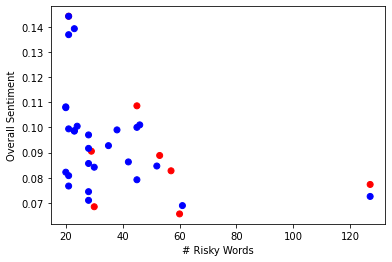

In [23]:
color_dict = {'fallen':'r', 'invest':'b'}
plt.scatter(y = text_data.positive_sentiment_mean-text_data.negetive_sentiment_mean, 
            x = text_data.risky_words, c= text_data.grade.apply(lambda x: color_dict[x]))
plt.xlabel('# Risky Words')
plt.ylabel('Overall Sentiment')

# plt.scatter(text_data.risky_words, text_data.total_words, c= text_data.grade.apply(lambda x: color_dict[x]))

In [209]:
import spacy
from textstat.textstat import textstatistics,legacy_round
 
# Splits the text into sentences, using
# Spacy's sentence segmentation which can
# be found at https://spacy.io/usage/spacy-101
nlp = spacy.load('en_core_web_lg')
def break_sentences(text):
    # nlp = spacy.load('en_core_web_lg')
    doc = nlp(text)
    return list(doc.sents)
 
# Returns Number of Words in the text
def word_count(text):
    sentences = break_sentences(text)
    words = 0
    for sentence in sentences:
        words += len([token for token in sentence])
    return words
 
# Returns the number of sentences in the text
def sentence_count(text):
    sentences = break_sentences(text)
    return len(sentences)
 
# Returns average sentence length
def avg_sentence_length(text):
    words = word_count(text)
    sentences = sentence_count(text)
    average_sentence_length = float(words / sentences)
    return average_sentence_length
 
# Textstat is a python package, to calculate statistics from
# text to determine readability,
# complexity and grade level of a particular corpus.
# Package can be found at https://pypi.python.org/pypi/textstat
def syllables_count(word):
    return textstatistics().syllable_count(word)
 
# Returns the average number of syllables per
# word in the text
def avg_syllables_per_word(text):
    syllable = syllables_count(text)
    words = word_count(text)
    ASPW = float(syllable) / float(words)
    return legacy_round(ASPW, 1)
 
# Return total Difficult Words in a text
def difficult_words(text):
    doc = nlp(text)
    # Find all words in the text
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [str(token) for token in sentence]
 
    # difficult words are those with syllables >= 2
    # easy_word_set is provide by Textstat as
    # a list of common words
    diff_words_set = set()
     
    for word in words:
        syllable_count = syllables_count(word)
        if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)
 
# A word is polysyllablic if it has more than 3 syllables
# this functions returns the number of all such words
# present in the text
def poly_syllable_count(text):
    count = 0
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [token for token in sentence]
     
 
    for word in words:
        syllable_count = syllables_count(word)
        if syllable_count >= 3:
            count += 1
    return count
 
 
 
def gunning_fog(text):
    per_diff_words = (difficult_words(text) / word_count(text) * 100) + 5
    grade = 0.4 * (avg_sentence_length(text) + per_diff_words)
    return grade

In [212]:
gunning_fog(text_data.clean_text.iloc[0])

13.83859192972858

In [211]:
# fog_index

text_data['fog_index'] = text_data.clean_text.progress_apply(lambda x: gunning_fog(x))

# for i in range(len(text_data)):
#     text_data.loc[i,'fog_index'] = gunning_fog(text_data.loc[i,'clean_text'])

  0%|          | 0/35 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [151]:
text_data.head()

,filename,text,cik,date,clean_text,review_clean_tokanize,postive_sentiment,negative_sentiment,total_words,risky_words,fog_index
0,0000001750_2015-05-31_10-K.txt,10-K 1 a2225345z10-k.htm 10-K Use these links ...,1750,2015-05-31 00:00:00,10k 1 a2225345z10khtm 10k use link rapidly rev...,"[10k, 1, a2225345z10khtm, 10k, use, link, rapi...",0.14,0.04,28486,36,8.182045
1,0000894315_2006-09-30_10-Q.txt,10-Q 1 l22661ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2006-09-30 00:00:00,10q 1 l22661ae10vqhtm developer diversified re...,"[10q, 1, l22661ae10vqhtm, developer, diversifi...",0.19,0.04,19455,28,146.530731
2,0000894315_2006-12-31_10-K.txt,10-K 1 l24241ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2006-12-31 00:00:00,10k 1 l24241ae10vkhtm developer diversified re...,"[10k, 1, l24241ae10vkhtm, developer, diversifi...",0.14,0.03,68034,61,90.189559
3,0000894315_2007-03-31_10-Q.txt,10-Q 1 l25860ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2007-03-31 00:00:00,10q 1 l25860ae10vqhtm developer diversified re...,"[10q, 1, l25860ae10vqhtm, developer, diversifi...",0.18,0.04,14261,23,195.820049
4,0000894315_2007-06-30_10-Q.txt,10-Q 1 l27074ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2007-06-30 00:00:00,10q 1 l27074ae10vqhtm developer diversified re...,"[10q, 1, l27074ae10vqhtm, developer, diversifi...",0.18,0.04,17321,21,166.295835


In [152]:
text_data.shape

(36, 11)

In [153]:
text_data.to_csv('../../../all_text_data.csv')